In [1]:
from skimage.filters import gabor_kernel
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt 
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

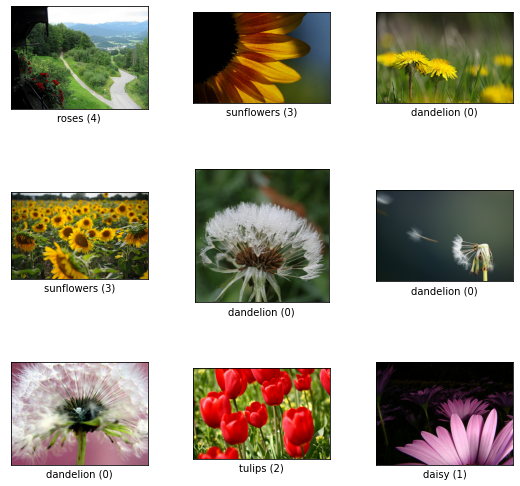

In [2]:
# Construct a tf.data.Dataset
ds, ds_info = tfds.load('tf_flowers', split='train', shuffle_files=True, with_info=True, as_supervised=True)

if isinstance(ds, list):
    fig = tfds.show_examples(ds[0], ds_info)
else:
    fig = tfds.show_examples(ds, ds_info)


In [3]:
ds_size = None
train_ds = None
train_size = None
test_ds = None
test_size = None

if isinstance(ds, list):
    train_ds = ds[0]
    train_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_ds = ds[1]
    test_size = tf.data.experimental.cardinality(test_ds).numpy()
    
    ds_size = train_size+test_size
    print("Data size:", ds_size)  
    print("Train size", train_size)
    print("Test size", test_size)
else:
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    print("Data size:", ds_size)

    train_ds = ds.take(0.7 * ds_size)
    train_size = tf.data.experimental.cardinality(train_ds).numpy()
    print("Train size", train_size)

    test_ds = ds.skip(0.7*ds_size)
    test_size = tf.data.experimental.cardinality(test_ds).numpy()
    print("Test size", test_size)


Data size: 3670
Train size 2569
Test size 1101


In [4]:
for image, label in ds.take(2):
    print(image)

tf.Tensor(
[[[ 88  97  30]
  [ 89  98  31]
  [ 90  99  32]
  ...
  [ 73  82  25]
  [ 74  83  26]
  [ 74  83  26]]

 [[ 89  98  31]
  [ 90  99  32]
  [ 91 100  33]
  ...
  [ 73  82  25]
  [ 74  83  26]
  [ 74  83  26]]

 [[ 91 101  32]
  [ 92 102  33]
  [ 93 103  34]
  ...
  [ 73  82  25]
  [ 73  82  25]
  [ 74  83  26]]

 ...

 [[ 30  37   3]
  [ 64  71  27]
  [113 115  52]
  ...
  [ 50  57  15]
  [ 50  57  15]
  [ 50  57  15]]

 [[ 44  47   2]
  [ 95  97  34]
  [147 145  60]
  ...
  [ 50  57  15]
  [ 50  57  15]
  [ 50  57  15]]

 [[ 87  85  34]
  [131 129  54]
  [172 167  67]
  ...
  [ 50  57  15]
  [ 50  57  15]
  [ 50  57  15]]], shape=(240, 182, 3), dtype=uint8)
tf.Tensor(
[[[  4 191   0]
  [ 69 165  40]
  [ 25 171  24]
  ...
  [ 35 169  20]
  [ 84 158  59]
  [ 10 198   0]]

 [[ 50 167  34]
  [176 147 151]
  [202 172 200]
  ...
  [199 188 202]
  [195 164 198]
  [ 64 176  66]]

 [[ 18 170  10]
  [162 159 166]
  [220 208 218]
  ...
  [209 213 196]
  [196 185 199]
  [ 24 177  24]]

 

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = 180
NUM_OF_CLASSES = 5

In [6]:
import math

def process_dataset(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
#     image = tf.image.per_image_standardization(image)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize images from 32x32 to 227x227
    image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

    image = image/255.0
    
#     label = tf.one_hot(tf.cast(label, tf.int32), NUM_OF_CLASSES)
        
    return image, label

def construct_dataset(ds):
    ds = ds.shuffle(buffer_size=BATCH_SIZE)
    ds = ds.map(process_dataset,num_parallel_calls=AUTOTUNE)
    
#     ds=ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_data = construct_dataset(train_ds)
test_data = construct_dataset(test_ds)

steps_per_epoch=math.ceil(train_size/BATCH_SIZE)
validation_steps=math.ceil(test_size/BATCH_SIZE)



In [7]:
print(tf.data.experimental.cardinality(test_data).numpy())
print(steps_per_epoch)
print(validation_steps)

35
81
35


In [8]:
for image, label in test_ds.take(1):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image/255.0
    
    print(image)
    print(label)
    label = tf.one_hot(tf.cast(label, tf.int32), NUM_OF_CLASSES)
#     print(image)
    print(label)

tf.Tensor(
[[[0.00119954 0.00189158 0.00292195]
  [0.00121492 0.00190696 0.00293733]
  [0.00119954 0.00193772 0.00295271]
  ...
  [0.00126105 0.00201461 0.0030296 ]
  [0.00124567 0.00199923 0.00301423]
  [0.00124567 0.00198385 0.00299885]]

 [[0.00121492 0.00190696 0.00293733]
  [0.00121492 0.00190696 0.00293733]
  [0.00121492 0.0019531  0.00296809]
  ...
  [0.00126105 0.00201461 0.0030296 ]
  [0.00124567 0.00199923 0.00301423]
  [0.00126105 0.00199923 0.00301423]]

 [[0.0012303  0.00192234 0.00295271]
  [0.00124567 0.00193772 0.00296809]
  [0.00126105 0.0019531  0.00298347]
  ...
  [0.00127643 0.00202999 0.00306036]
  [0.00126105 0.00201461 0.00304498]
  [0.00126105 0.00198385 0.0030296 ]]

 ...

 [[0.00178393 0.00261438 0.00356786]
  [0.00179931 0.00262976 0.00358324]
  [0.00181469 0.00267589 0.00361399]
  ...
  [0.00183007 0.00267589 0.00366013]
  [0.00183007 0.00267589 0.00366013]
  [0.00184544 0.00267589 0.00366013]]

 [[0.00178393 0.00261438 0.00356786]
  [0.00178393 0.00264514 0

In [10]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers

# classifier = Sequential([
# #     experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
#     Conv2D(64, (3, 3), strides=(2, 2),activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
#     BatchNormalization(),
#     MaxPooling2D(pool_size = (2, 2)),
#     Conv2D(128, (3, 3), strides=(1, 1), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size = (2, 2)),
#     Flatten(),Dropout(0.5),
#     Dense(units = 256, activation = 'relu'),
#     Dropout(0.2),
#     Dense(units = 64, activation = 'relu'),Dropout(0.1),
#     Dense(units = NUM_OF_CLASSES)
# ])

classifier = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_OF_CLASSES)
])



# Compiling the CNN
# opt = RMSprop(learning_rate=0.001)
# opt = Adam(learning_rate=0.01)

# classifier.compile(optimizer = opt, loss = 'binary_crossentropy', 
#                    metrics = ['accuracy'])

classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0

In [11]:
epochs=10
history = classifier.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Epoch 1/10
81/81 [==============================] - 43s 530ms/step - loss: 1.6043 - accuracy: 0.2491 - val_loss: 1.6072 - val_accuracy: 0.2234
Epoch 2/10
81/81 [==============================] - 46s 566ms/step - loss: 1.5970 - accuracy: 0.2546 - val_loss: 1.6105 - val_accuracy: 0.2216
Epoch 3/10
81/81 [==============================] - 48s 595ms/step - loss: 1.5969 - accuracy: 0.2550 - val_loss: 1.6104 - val_accuracy: 0.2243
Epoch 4/10
81/81 [==============================] - 45s 554ms/step - loss: 1.5968 - accuracy: 0.2538 - val_loss: 1.6116 - val_accuracy: 0.2216
Epoch 5/10
81/81 [==============================] - 47s 580ms/step - loss: 1.5965 - accuracy: 0.2550 - val_loss: 1.6109 - val_accuracy: 0.2216
Epoch 6/10
81/81 [==============================] - 49s 603ms/step - loss: 1.5970 - accuracy: 0.2538 - val_loss: 1.6111 - val_accuracy: 0.2234
Epoch 7/10
81/81 [==============================] - 50s 615ms/step - loss: 1.5983 - accuracy: 0.2518 - val_loss: 1.6100 - val_accuracy: 0.2243

In [ ]:
# Fitting the CNN to the images

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)



hist = classifier.fit(train_data,  epochs=1000, 
                   callbacks=[stop_alg, reduce_lr], 
                      validation_steps=validation_steps,
                      steps_per_epoch=steps_per_epoch,
                   validation_data=test_data)



Epoch 1/1000
81/81 [==============================] - 45s 551ms/step - loss: 1.5968 - accuracy: 0.2542 - val_loss: 1.6108 - val_accuracy: 0.2243
Epoch 2/1000
81/81 [==============================] - 47s 578ms/step - loss: 1.5969 - accuracy: 0.2546 - val_loss: 1.6107 - val_accuracy: 0.2216
Epoch 3/1000
81/81 [==============================] - 52s 641ms/step - loss: 1.5986 - accuracy: 0.2511 - val_loss: 1.6102 - val_accuracy: 0.2216
Epoch 4/1000
81/81 [==============================] - 48s 599ms/step - loss: 1.5969 - accuracy: 0.2542 - val_loss: 1.6105 - val_accuracy: 0.2216
Epoch 5/1000
81/81 [==============================] - 52s 638ms/step - loss: 1.5966 - accuracy: 0.2546 - val_loss: 1.6100 - val_accuracy: 0.2262
Epoch 6/1000
81/81 [==============================] - 50s 622ms/step - loss: 1.5966 - accuracy: 0.2550 - val_loss: 1.6106 - val_accuracy: 0.2243
Epoch 7/1000
81/81 [==============================] - 52s 646ms/step - loss: 1.5965 - accuracy: 0.2550 - val_loss: 1.6115 - val_ac